# The Baluev Method for False Alarm Probabilities
**Author**: Nicholas Hunt-Walker<br/>
**Date**: 9/14/2015<br/>
**Purpose**: We want to estimate the probability that a given periodogram Z-score is a false positive. Modeled after Monte-Carlo simulations of Gaussian white noise, <a href="http://adsabs.harvard.edu/abs/2008MNRAS.385.1279B">Baluev 2008</a> demonstrated that upper limits to False Alarm Probabilities (FAPs) can be estimated from elements of the data and evaluations from a given periodogram. Here, we reproduce the comparison between FAPs as derived from data and FAPs calculated from Baluev's theoretical model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from gatspy.periodic import LombScargle


## Set up simulation of Gaussian white noise

In [2]:
# Want 100,000 trials
N_trials = 100000
# 1,000 time points, evenly spaced
N_pts = 1000

# time array
t = np.linspace(0, 100, N_pts)

# W = max(f) * T
W = [50, 500]
scores = np.zeros((N_trials, len(W)))


## Run the simulation
\*\*Note: Don't actually run this. It'll take forever. Run smaller instances in terminals and restitch the data later\*\*

In [ ]:
for ii in range(N_trials):

    for jj in range(len(W)):
        # maximum frequency/min period
        fmax = W[jj]/t.max()
        
        # "data" array
        y = np.random.normal(0, 1.0, t.size)

        ls = LombScargle().fit(t, y, 1.0)
        ls.optimizer.quiet = True
        ls.optimizer.period_range = (1/fmax, t[-1])

        chisq_0 = np.var(y)
        scores[ii, jj] = ls.score(ls.best_period) * chisq_0 * 0.5 * (N_pts-1)


## Calculate maximum FAPs from Baluev 2008, Table 1

In [3]:
def false_alarm_single(t, z):
    N = t.size
    Nh = N-1
    Nk = N-3

    p = (1 - 2*z/Nh)**(0.5*Nk)
    return p

def false_alarm_max(t, W, z):
    N = t.size
    Nh = N-1
    Nk = N-3

    fmax = W/t.max()

    tau = W * (1-2*z/Nh) ** (0.5*(Nk-1)) * np.sqrt(z)
    Psingle = 1 - false_alarm_single(t, z)
    Pmax = Psingle * np.exp(-tau)

    return 1 - Pmax

In [4]:
scores = np.linspace(0, 20, 1000)
faps_50 = false_alarm_max(t, W[0], scores)
faps_500 = false_alarm_max(t, W[1], scores)


## Load results of the simulations

In [5]:
data = np.loadtxt("all_gaussian.dat", delimiter=",").T

In [6]:
## Freeman-Diaconis bin-width for histograms
qw1 = np.percentile(data[0], [75,25])
qw1 = qw1[0] - qw1[1]
bw1 = 2*qw1 / (N_trials)**(1./3)

qw2 = np.percentile(data[1], [75,25])
qw2 = qw2[0] - qw2[1]
bw2 = 2*qw2 / (N_trials)**(1./3)


In [7]:
H1, bins1 = np.histogram(data[0], bins=np.arange(0, max(data[0]) + bw1, bw1))
H2, bins2 = np.histogram(data[1], bins=np.arange(0, max(data[1]) + bw2, bw2))
H1 = np.cumsum(H1)
H2 = np.cumsum(H2)


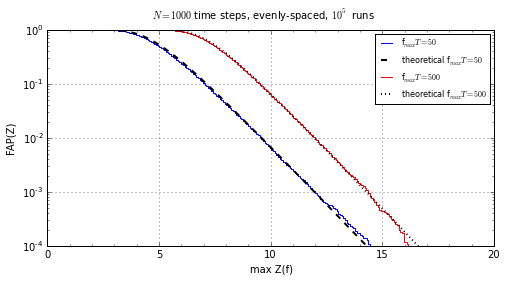

In [8]:
fig = plt.figure(figsize=(8,4))
fig.subplots_adjust(bottom=0.15)
plt.suptitle("$N = 1000$ time steps, evenly-spaced, $10^5$ runs")

ax = plt.subplot(111)
ax.step(bins1[:-1], 1 - H1/float(max(H1)), color='b', label="f$_{max}T = 50$")
ax.plot(scores, faps_50, color='k', linewidth=2, linestyle='--', label="theoretical f$_{max}T=50$")
ax.step(bins2[:-1], 1 - H2/float(max(H2)), color='r', label="f$_{max}T = 500$")
ax.plot(scores, faps_500, color='k', linewidth=2, linestyle=':', label="theoretical f$_{max}T=500$")
ax.set_xlabel("max Z(f)")
ax.set_ylabel("FAP(Z)")
ax.legend(loc="best", fontsize=8)
ax.set_ylim(1E-4,1)
ax.set_xlim(0, 20)
ax.set_yscale("log")
ax.minorticks_on()
ax.grid()

plt.show()
